In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ
from qiskit import Aer
from qiskit import execute
from qiskit import transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [28]:
IBMQ.load_account()

In [3]:
# use this function to plot measurement results
# alternatively, use plot_histogram
def visualize_counts(counts_dict, plt=plt):
    """
    take a dictionary of measurement results and
    plot it as a bar chart
    """
    N_bits = len(list(counts_dict.keys())[0])
    N_values = 2**N_bits
    
    values = [ i for i in range(N_values) ]
    labels = [ bin(i)[2:].zfill(N_bits) for i in range(N_values)]
    counts = [ counts_dict.get(label,0) for label in labels ]
    
    plt.bar(values, counts/np.sum(counts), tick_label=labels)
    plt.xlabel("measurement outcome")
    plt.ylabel("probability")
    return plt


# use this function to display state tomography results
# alternatively, use plot_state_city
def visualize_two_qubit_tomography(tomo_data, clim_real=None, clim_imag=None):
    # safety check
    if np.shape(tomo_data) != (4,4):
        print ("The input must be a numpy array of shape (4,4).")
        return 
    
    # adjust plot ranges automatically
    if clim_real is None:
        clim_real = np.max(np.abs(np.real(tomo_data)))
    if clim_imag is None:
        clim_imag = np.max(np.abs(np.imag(tomo_data)))
    
    # plot real and imaginary part
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(np.real(tomo_data), cmap='RdBu')
    plt.clim(-clim_real,clim_real)
    plt.title("real part")
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(np.imag(tomo_data), cmap='RdBu')
    plt.clim(-clim_imag,clim_imag)
    plt.title("imaginary part")
    plt.colorbar()
    

# convert a state vector to a density matrix
def statevector_to_density_matrix(vec):
    return np.transpose(np.conjugate(np.array([vec]))) * np.array([vec])

In [9]:
# define a quantum register with 2 qubits
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')

# Transpiling a circuit

In [10]:
def encode_classical_information(x, qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc (assumed to be
    in the state |0...0>) such that the integer number x 
    in {0,1,2,3} is encoded into the quantum state
    """
    if x%4 == 1:
        qc.x(qubit0)
    elif x%4 == 2:
        qc.x(qubit1)
    elif x%4 == 3:
        qc.x(qubit0)
        qc.x(qubit1)
    
    return qc

In [11]:
def generate_Bell_state(qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc
    to generate a Bell state
    """
    qc.h(qubit0)
    qc.cnot(qubit0, qubit1)
    
    return qc

In [12]:
def prepare_Bell_state(x, qr, cr):
    qc = QuantumCircuit(qr, cr)
    qc = encode_classical_information(x, qc, qr[0], qr[1])
    qc.barrier()
    qc = generate_Bell_state(qc, qr[0], qr[1])
    
    return qc

In [13]:
def measure_Bell_state(x, qr, cr):
    qc = prepare_Bell_state(x,qr,cr)
    qc.barrier()
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    
    return qc

In [14]:
# generate and visualize a quantum circuit:
qc_virtual = measure_Bell_state(2, qr, cr)
qc_virtual.draw()

░ ┌───┐      ░ ┌─┐   
q_0: ──────░─┤ H ├──■───░─┤M├───
     ┌───┐ ░ └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ┤ X ├─░──────┤ X ├─░──╫─┤M├
     └───┘ ░      └───┘ ░  ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

In [15]:
# select a real quantum computer and read out its (current!) noise properties
backend = IBMQ.get_provider('ibm-q').get_backend('ibmq_valencia')
noise_model = NoiseModel.from_backend(backend)

In [16]:
# get the coupling map and the basis gates
coupling_map = backend.configuration().coupling_map
basis_gates = backend.configuration().basis_gates
print (coupling_map)
print (basis_gates)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
['id', 'u1', 'u2', 'u3', 'cx']


In [17]:
# define a layout, i.e., a mapping from virtual qubits to physical qubits on the device
layouts = [ {qr[0]: 0, qr[1]: 1},
            {qr[0]: 3, qr[1]: 4}, 
            {qr[0]: 0, qr[1]: 4} ]

In [18]:
# transpile all circuits according to this layout
circuits = [ transpile(qc_virtual, 
                       backend=backend, 
                       basis_gates=basis_gates, 
                       coupling_map=coupling_map, 
                       initial_layout=layout) 
            for layout in layouts ]

In [19]:
# visualize the raw circuit
qc_virtual.draw()

░ ┌───┐      ░ ┌─┐   
q_0: ──────░─┤ H ├──■───░─┤M├───
     ┌───┐ ░ └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ┤ X ├─░──────┤ X ├─░──╫─┤M├
     └───┘ ░      └───┘ ░  ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

In [20]:
# visualize the transpiled circuits
circuits[0].draw()

░ ┌─────────┐      ░ ┌─┐   
      q_0 -> 0 ──────────────░─┤ U2(0,π) ├──■───░─┤M├───
               ┌───────────┐ ░ └─────────┘┌─┴─┐ ░ └╥┘┌─┐
      q_1 -> 1 ┤ U3(π,0,π) ├─░────────────┤ X ├─░──╫─┤M├
               └───────────┘ ░            └───┘ ░  ║ └╥┘
ancilla_0 -> 2 ────────────────────────────────────╫──╫─
                                                   ║  ║ 
ancilla_1 -> 3 ────────────────────────────────────╫──╫─
                                                   ║  ║ 
ancilla_2 -> 4 ────────────────────────────────────╫──╫─
                                                   ║  ║ 
          c: 2/════════════════════════════════════╩══╩═
                                                   0  1

In [21]:
circuits[1].draw()

ancilla_0 -> 0 ─────────────────────────────────────────
                                                        
ancilla_1 -> 1 ─────────────────────────────────────────
                                                        
ancilla_2 -> 2 ─────────────────────────────────────────
                             ░ ┌─────────┐      ░ ┌─┐   
      q_0 -> 3 ──────────────░─┤ U2(0,π) ├──■───░─┤M├───
               ┌───────────┐ ░ └─────────┘┌─┴─┐ ░ └╥┘┌─┐
      q_1 -> 4 ┤ U3(π,0,π) ├─░────────────┤ X ├─░──╫─┤M├
               └───────────┘ ░            └───┘ ░  ║ └╥┘
          c: 2/════════════════════════════════════╩══╩═
                                                   0  1

In [17]:
circuits[2].draw()

░ ┌─────────┐     ┌───┐           ░       
      q_0 -> 0 ──────────────░─┤ U2(0,π) ├──■──┤ X ├──■────────░───────
                             ░ └─────────┘┌─┴─┐└─┬─┘┌─┴─┐      ░ ┌─┐   
ancilla_0 -> 1 ───────────────────────────┤ X ├──■──┤ X ├──■───░─┤M├───
                                          └───┘     └───┘  │   ░ └╥┘   
ancilla_1 -> 2 ────────────────────────────────────────────┼───░──╫────
                                          ┌───┐          ┌─┴─┐ ░  ║ ┌─┐
ancilla_2 -> 3 ─────────────────────■─────┤ X ├──■───────┤ X ├─░──╫─┤M├
               ┌───────────┐ ░    ┌─┴─┐   └─┬─┘┌─┴─┐     └───┘ ░  ║ └╥┘
      q_1 -> 4 ┤ U3(π,0,π) ├─░────┤ X ├─────■──┤ X ├───────────░──╫──╫─
               └───────────┘ ░    └───┘        └───┘           ░  ║  ║ 
          c: 2/═══════════════════════════════════════════════════╩══╩═
                                                                  0  1

In [22]:
# execute the transpiled circuits
job_transpiled = execute(circuits, Aer.get_backend('qasm_simulator'), shots=8192, 
                         backend_properties=backend.properties(),
                         noise_model=noise_model)
results_transpiled = job_transpiled.result()

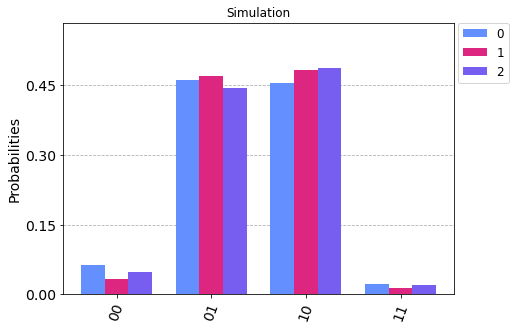

In [23]:
# visualize the results
plot_histogram(results_transpiled.get_counts(),
               legend=[str(x) for x in range(len(circuits))],
               bar_labels=False,
               title='Simulation')

<hr>

# Executing a job on real hardware

In [29]:
#job_ibm = execute(circuits, backend=backend, shots=8192)
#job_monitor(job_ibm)
#print (job_ibm.job_id())
print ("Job Status: job has successfully run")
print ("5fc25ef7c9e97f00199c9400")

Job Status: job has successfully run
5fc25ef7c9e97f00199c9400


In [26]:
# retrieve results using the IBM job id
job_results = backend.retrieve_job('5fc25ef7c9e97f00199c9400')

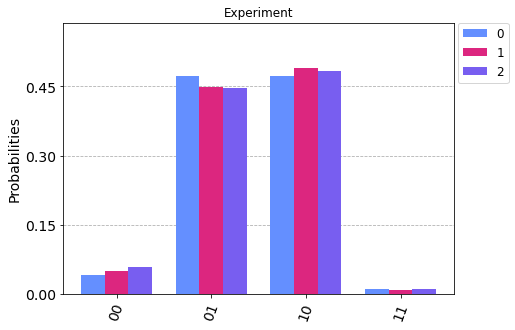

In [27]:
# visualize the results
plot_histogram(job_results.result().get_counts(),
               legend=[str(x) for x in range(len(circuits))],
               bar_labels=False,
               title='Experiment')

<hr>